In [387]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import metapredict as meta

import warnings
warnings.filterwarnings("ignore")
from statsmodels.nonparametric.smoothers_lowess import lowess

import glob

In [46]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [47]:
# Define colors for the domains
AD_color = 'orange'
RD_color = 'red'
DBD_color = 'purple'

# Summary figures

For each of Caitlin's TFs, generate a panel with the following figures:
- AD / DBD/ RD annotations
- Variants
- Conservation
    - Zoonomia CDS
    - Zoonomia protein alignment
- Predictions
    - Disorder
    - Activity predictor traces
- Alpha fold structure

Plan - first make helper function for each, then later make subplots

In [48]:
# Loading in info about the ADs
cc_names = pd.read_excel("../data/gene_names_with_location_and_pmvs.xlsx")
cc_names = cc_names.rename(columns = {"gene" : "Gene", "start" : "Start", "end" : "End"})
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
cc_names = pd.merge(known_ADs[["uniprotID", "Gene", "Start", "End"]], cc_names)
ensts = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)
cc_names = pd.merge(cc_names, ensts)
cc_names["ENST"] = cc_names["ENST"].str.split(".").str[0]
cc_names["len"] = cc_names["End"] - cc_names["Start"] + 1
cc_names = cc_names.rename(columns = {"Start" : "start", "End" : "end"})
cc_names

,uniprotID,Gene,start,end,pMVS #,Gene Name,ENST,len
0,O94983,CAMTA2,285,468,404,CAMTA2_AD1,ENST00000348066,184
1,O94983,CAMTA2,472,581,405,CAMTA2_AD2,ENST00000348066,110
2,P11308,ERG,433,479,400,ERG_AD1,ENST00000288319,47
3,P11308,ERG,118,261,406,ERG_AD2,ENST00000288319,144
4,Q13422,IKZF1,284,365,402,IKZF1_AD,ENST00000331340,82
5,O14770,MEIS2,340,477,377,MEIS2_AD,ENST00000561208,138
6,Q15788,NCOA1,1241,1385,379,NCOA1_AD2,ENST00000348332,145
7,Q15788,NCOA1,840,1011,380,NCOA1_AD3,ENST00000348332,172
8,O95096,NKX2-2,220,273,381,NKX2-2_AD,ENST00000377142,54
9,P43354,NR4A2,1,91,382,NR4A2_AD1,ENST00000339562,91


In [49]:
cc_TFs = cc_names[["uniprotID", "Gene"]].drop_duplicates()
cc_TFs

,uniprotID,Gene
0,O94983,CAMTA2
2,P11308,ERG
4,Q13422,IKZF1
5,O14770,MEIS2
6,Q15788,NCOA1
8,O95096,NKX2-2
9,P43354,NR4A2
11,P32242,OTX1
12,Q02548,PAX5
13,P26367,PAX6


# 1. Annotations

In [50]:
# Loading table with all domain info
TFs_tbl = pd.read_csv("../soto_analysis/outputs/all_TFs_table_proteins.txt", sep = "\t", index_col = 0)

# Adding coordinates to cc TFs length
cc_TFs = pd.merge(cc_TFs, TFs_tbl, on = "uniprotID", how = "left")

# Adding full TF length 
lambert_TFs = pd.read_csv("../output/lambert_TFs_10-21-24_with_DBD_coords.csv")
lambert_TFs["uniprotID"] = lambert_TFs["id"].str.split("|").str[1]
lambert_TFs["len"] = lambert_TFs["ProteinSeq"].str.len()
cc_TFs = pd.merge(cc_TFs, lambert_TFs[["uniprotID", "len", "ProteinSeq"]], on = "uniprotID", how = "left")
cc_TFs = cc_TFs.fillna("0-0")
cc_TFs

,uniprotID,Gene,1,2,ENSG,ENST,DBD_coords,AD_coords,RD_coords,Bif_coords,length,len,ProteinSeq
0,O94983,CAMTA2,0-0,0-0,0-0,ENST00000348066,37-149,"285-468,472-581","205-284,535-843",0-0,1,1202,MNTKDTTEVAENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTNEE...
1,P11308,ERG,0-0,0-0,0-0,ENST00000288319,312-391,"433-479,118-261","39-278,389-468",0-0,1,479,MASTIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSSDYGQTSK...
2,Q13422,IKZF1,0-0,0-0,0-0,ENST00000331340,"117-139,145-167,173-195,201-224",284-365,1-477,0-0,1,519,MDADEGQDMSQVSGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQS...
3,O14770,MEIS2,0-0,0-0,0-0,ENST00000561208,277-334,340-477,137-180,0-0,1,477,MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLH...
4,Q15788,NCOA1,0-0,0-0,0-0,ENST00000348332,26-81,"1-93,1241-1385,840-1011","62-171,312-391,652-1011,1112-1191",0-0,1,1441,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...
5,O95096,NKX2-2,0-0,0-0,0-0,ENST00000377142,129-185,220-273,"8-18,112-217",0-0,1,273,MSLTNTKTGFSVKDILDLPDTNDEEGSVAEGPEEENEGPEPAKRAG...
6,P43354,NR4A2,0-0,0-0,0-0,ENST00000339562,261-330,"1-91,584-598","42-188,299-378,409-488",0-0,1,598,MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...
7,P32242,OTX1,0-0,0-0,0-0,ENST00000282549,39-95,172-354,0-0,0-0,1,354,MMSYLKQPPYGMNGLGLAGPAMDLLHPSVGYPATPRKQRRERTTFT...
8,Q02548,PAX5,0-0,0-0,0-0,ENST00000358127,16-140,304-358,316-348,0-0,1,391,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...
9,P26367,PAX6,0-0,0-0,0-0,ENST00000241001,"4-128,211-267",271-422,0-0,0-0,1,422,MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRIL...


In [51]:
# Convert string format ranges to int tuples
def return_new_ranges(col):
    split = cc_TFs[col].str.split(',')
    new_ranges = []
    for TF_ranges in split:
        new_TF_ranges = []
        for indiv_range in TF_ranges:
            new_TF_ranges.append((int(indiv_range.split("-")[0]),
                                 int(indiv_range.split("-")[1])))
        new_ranges.append(new_TF_ranges)
    
    return new_ranges

cc_TFs["DBD_ranges"] = return_new_ranges("DBD_coords")
cc_TFs["AD_ranges"] = return_new_ranges("AD_coords")
cc_TFs["RD_ranges"] = return_new_ranges("RD_coords")
cc_TFs

,uniprotID,Gene,1,2,ENSG,ENST,DBD_coords,AD_coords,RD_coords,Bif_coords,length,len,ProteinSeq,DBD_ranges,AD_ranges,RD_ranges
0,O94983,CAMTA2,0-0,0-0,0-0,ENST00000348066,37-149,"285-468,472-581","205-284,535-843",0-0,1,1202,MNTKDTTEVAENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTNEE...,"[(37, 149)]","[(285, 468), (472, 581)]","[(205, 284), (535, 843)]"
1,P11308,ERG,0-0,0-0,0-0,ENST00000288319,312-391,"433-479,118-261","39-278,389-468",0-0,1,479,MASTIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSSDYGQTSK...,"[(312, 391)]","[(433, 479), (118, 261)]","[(39, 278), (389, 468)]"
2,Q13422,IKZF1,0-0,0-0,0-0,ENST00000331340,"117-139,145-167,173-195,201-224",284-365,1-477,0-0,1,519,MDADEGQDMSQVSGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQS...,"[(117, 139), (145, 167), (173, 195), (201, 224)]","[(284, 365)]","[(1, 477)]"
3,O14770,MEIS2,0-0,0-0,0-0,ENST00000561208,277-334,340-477,137-180,0-0,1,477,MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLH...,"[(277, 334)]","[(340, 477)]","[(137, 180)]"
4,Q15788,NCOA1,0-0,0-0,0-0,ENST00000348332,26-81,"1-93,1241-1385,840-1011","62-171,312-391,652-1011,1112-1191",0-0,1,1441,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,"[(26, 81)]","[(1, 93), (1241, 1385), (840, 1011)]","[(62, 171), (312, 391), (652, 1011), (1112, 11..."
5,O95096,NKX2-2,0-0,0-0,0-0,ENST00000377142,129-185,220-273,"8-18,112-217",0-0,1,273,MSLTNTKTGFSVKDILDLPDTNDEEGSVAEGPEEENEGPEPAKRAG...,"[(129, 185)]","[(220, 273)]","[(8, 18), (112, 217)]"
6,P43354,NR4A2,0-0,0-0,0-0,ENST00000339562,261-330,"1-91,584-598","42-188,299-378,409-488",0-0,1,598,MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...,"[(261, 330)]","[(1, 91), (584, 598)]","[(42, 188), (299, 378), (409, 488)]"
7,P32242,OTX1,0-0,0-0,0-0,ENST00000282549,39-95,172-354,0-0,0-0,1,354,MMSYLKQPPYGMNGLGLAGPAMDLLHPSVGYPATPRKQRRERTTFT...,"[(39, 95)]","[(172, 354)]","[(0, 0)]"
8,Q02548,PAX5,0-0,0-0,0-0,ENST00000358127,16-140,304-358,316-348,0-0,1,391,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...,"[(16, 140)]","[(304, 358)]","[(316, 348)]"
9,P26367,PAX6,0-0,0-0,0-0,ENST00000241001,"4-128,211-267",271-422,0-0,0-0,1,422,MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRIL...,"[(4, 128), (211, 267)]","[(271, 422)]","[(0, 0)]"


In [278]:
def plot_rectangle(start, end, color, box_height, ax, y = 0, alpha = 0.7):
    rectangle = patches.Rectangle((start, y), width=end - start, height=box_height, linewidth=1, edgecolor='none', facecolor=color, alpha=alpha)
    ax.add_patch(rectangle)

In [434]:
def plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, box_height, DBD_y, AD_y, RD_y, ax, RD = True, AD_text = True, alpha = 0.7):
    
    for start, end in AD_coords:
        #print(start, end)
        plot_rectangle(start, end, AD_color, box_height, ax, y = AD_y, alpha = alpha)

        if AD_text:
            cc_names_row = cc_names[(cc_names["start"] == start) & (cc_names["end"] == end)]
            if len(cc_names_row) > 0:
                AD_name = cc_names_row["Gene Name"].iloc[0]
                if AD_name[-1] in ["1", "2", "3"]:
                    AD_name = "AD" + AD_name[-1]
                    ax.text(np.mean([start, end]), AD_y + 0.5 * box_height, 
                             AD_name, 
                             fontsize=11, 
                             color="black", 
                             horizontalalignment='center',
                            verticalalignment='center')

    if RD:
        for start, end in RD_coords:
            plot_rectangle(start, end, RD_color, box_height, ax, y = box_height, alpha = alpha)
        
    for start, end in DBD_coords:
        plot_rectangle(start, end, DBD_color, box_height, ax, y = DBD_y, alpha = alpha)
    

In [694]:
sns.set_context('paper')

import matplotlib.patches as patches

# Plots DBD, AD, and RD annotations
def plot_annots(DBD_coords, AD_coords, RD_coords, TF_len, ax, box_height = 0.3, RD = False):
    
    #plt.figure(figsize = (8, 0.75))
    #ax.axhline(y = 0, color = 'black', linestyle = '-', lw = 2) 
    #ax.axhline(y = box_height, color = 'black', linestyle = '--', lw = 1, alpha = 0.1) 
    #ax.axhline(y = 2 * box_height, color = 'black', linestyle = '--', lw = 1, alpha = 0.1) 
    
    
    plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, box_height,
                          DBD_y = 0,
                            AD_y = 0,
                          RD_y = box_height, ax =ax, alpha = 0.5, RD = False)
    
        
    # Adjust plot limits so that the rectangles are visible
    ax.set_ylim(0, 1)  # y-limits remain from 0 to 1, as the plot height is small
    #plt.axis('off')
    
    #plt.yticks([box_height / 2, box_height * 1.5], ['DBD', 'AD'])
    plt.yticks([])
    
    y_labels = ax.get_yticklabels()
    
    color_dict = {"AD" : AD_color, "RD" : RD_color, "DBD" : DBD_color}

    # for i, label in enumerate(y_labels):
    #     domain_type = re.search("'(.*)'", str(label))[0][1:-1]
    #     label.set_color(color_dict[domain_type])

    ax.set_xlim(0, TF_len)  # Adjust x-limits to fit rectangles (based on start and end values)
    ax.set_xlabel("Protein Residue", labelpad = 0)
    
    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    new_tick_locations = np.arange(0, TF_len * 3 + 1, 300)
    ax2.spines["bottom"].set_position(("axes", -0.7))
    
    ax2.spines["bottom"].set_color(sns.color_palette('muted')[0])
    
    #ax2.set_frame_on(True)
    #ax2.patch.set_visible(False)
    
    # for sp in ax2.spines.itervalues():
    #     sp.set_visible(False)
    #ax2.spines["bottom"].set_visible(True)
    
    ax2.set_xticks(new_tick_locations)
    #ax2.set_xticklabels(new_tick_locations)
    ax2.tick_params(axis='x', colors=sns.color_palette('muted')[0])
    ax2.set_xlabel(r"CDS Nucleotide", color = sns.color_palette('muted')[0], labelpad = 0)
    sns.despine(left = True, ax = ax)
    sns.despine(left = True, ax = ax2)

    

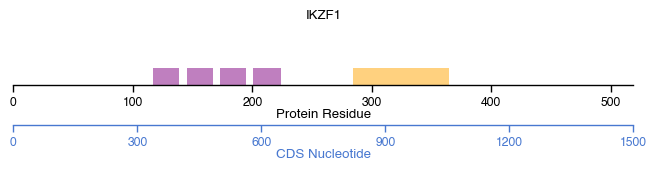

In [695]:
for i in [cc_TFs.index[2]]:
#for i in cc_TFs.index:
    fig, ax = plt.subplots(figsize=(8, 0.75))
    
    plot_annots(cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                cc_TFs["len"].iloc[i], ax)
    plt.title(cc_TFs["Gene"].iloc[i])

# 2. Disorder

In [674]:
def plot_disorder(gene, DBD_coords, AD_coords, RD_coords, ax):
    tbl_row = cc_TFs[cc_TFs["Gene"] == gene]
    disorder = meta.predict_disorder(tbl_row["ProteinSeq"].iloc[0])
    sns.lineplot(x = np.arange(len(disorder)), y = disorder, ax = ax, color = "black")
    ax.set_xlim(0, len(disorder))



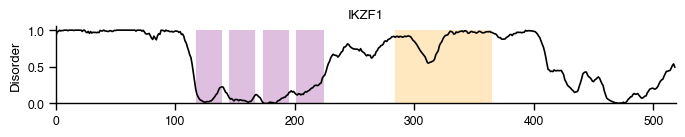

In [675]:
for i in [cc_TFs.index[2]]:
#for i in cc_TFs.index:
    fig, ax = plt.subplots(figsize=(8, 1))
    
    plot_disorder(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                 ax = ax)
    
    plot_domain_rectangles(cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 1, RD = False, AD_text = False, alpha = 0.25,
                          DBD_y = 0, AD_y = 0, RD_y = 0, ax = ax)

    ax.set_ylim(0, 1.05)
    plt.ylabel("Disorder")
    plt.title(cc_TFs["Gene"].iloc[i])
    sns.despine()
    plt.show()

# 3. Activity predictor traces

In [175]:
# From Savio, adding predictions
preds = pd.read_csv("../data/all_pred_cc_genes.csv", index_col = 0)
for col in preds.columns[1:]:
    preds[col] = preds[col].str[1:-1].str.replace(" ", "").str.split(",")
    
    preds[col] = [[float(_) for _ in str_list] for str_list in preds[col]]
cc_TFs = pd.merge(cc_TFs, preds, left_on = "ProteinSeq", right_on = "sequence", how = "left")
cc_TFs

,uniprotID,Gene,1,2,ENSG,ENST,DBD_coords,AD_coords,RD_coords,Bif_coords,...,AD_ranges,RD_ranges,sequence,paddle_centers,paddle_preds,adpred_preds,adhunter_centers,adhunter_preds,tada_centers,tada_preds
0,O94983,CAMTA2,0-0,0-0,0-0,ENST00000348066,37-149,"285-468,472-581","205-284,535-843",0-0,...,"[(285, 468), (472, 581)]","[(205, 284), (535, 843)]",MNTKDTTEVAENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTNEE...,"[27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....","[-0.013730620965361595, 0.0014786720275878906,...","[7.913487206678838e-05, 0.00014801321958657354...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[26216.07421875, 31656.9453125, 30135.41796875...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[0.1592683643102646, 0.16133619844913483, 0.16..."
1,P11308,ERG,0-0,0-0,0-0,ENST00000288319,312-391,"433-479,118-261","39-278,389-468",0-0,...,"[(433, 479), (118, 261)]","[(39, 278), (389, 468)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q13422,IKZF1,0-0,0-0,0-0,ENST00000331340,"117-139,145-167,173-195,201-224",284-365,1-477,0-0,...,"[(284, 365)]","[(1, 477)]",MDADEGQDMSQVSGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQS...,"[27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....","[0.25299009680747986, 0.23928268253803253, 0.2...","[0.00044040323700755835, 0.000509298755787313,...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21660.33984375, 17697.76171875, 16628.2304687...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[0.2258308380842209, 0.2093046009540558, 0.206..."
3,O14770,MEIS2,0-0,0-0,0-0,ENST00000561208,277-334,340-477,137-180,0-0,...,"[(340, 477)]","[(137, 180)]",MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLH...,"[27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....","[0.8199502825737, 0.8594822883605957, 0.866415...","[0.002523460192605853, 0.0030293811578303576, ...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[49162.22265625, 44042.8046875, 41100.48828125...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[0.19317132234573364, 0.19302818179130554, 0.2..."
4,Q15788,NCOA1,0-0,0-0,0-0,ENST00000348332,26-81,"1-93,1241-1385,840-1011","62-171,312-391,652-1011,1112-1191",0-0,...,"[(1, 93), (1241, 1385), (840, 1011)]","[(62, 171), (312, 391), (652, 1011), (1112, 11...",MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,"[27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....","[0.5049787759780884, 0.6081094145774841, 0.753...","[0.0005537507822737098, 0.000426911108661443, ...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21515.890625, 22503.7421875, 29914.375, 33283...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[0.16599246859550476, 0.15999025106430054, 0.1..."
5,O95096,NKX2-2,0-0,0-0,0-0,ENST00000377142,129-185,220-273,"8-18,112-217",0-0,...,"[(220, 273)]","[(8, 18), (112, 217)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,P43354,NR4A2,0-0,0-0,0-0,ENST00000339562,261-330,"1-91,584-598","42-188,299-378,409-488",0-0,...,"[(1, 91), (584, 598)]","[(42, 188), (299, 378), (409, 488)]",MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...,"[27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....","[5.631446361541748, 5.523930072784424, 5.58192...","[0.00040724125574342906, 0.0004007562529295683...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[105978.453125, 82591.7734375, 84743.59375, 86...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[0.5261314511299133, 0.4855295717716217, 0.525..."
7,P32242,OTX1,0-0,0-0,0-0,ENST00000282549,39-95,172-354,0-0,0-0,...,"[(172, 354)]","[(0, 0)]",MMSYLKQPPYGMNGLGLAGPAMDLLHPSVGYPATPRKQRRERTTFT...,"[27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....","[0.4895004332065582, 0.4885059893131256, 0.489...","[0.0024891661014407873, 0.002230012323707342, ...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[59017.9921875, 48401.6875, 48357.9609375, 487...","[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[0.20742511749267578, 0.20668350160121918, 0.2..."
8,Q02548,PAX5,0-0,0-0,0-0,ENST00000358127,16-140,304-358,316-348,0-0,...,"[(304, 358)]","[(316, 348)]",MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLP

In [644]:
def norm_preds(preds, threshold):
    return (np.array(preds) - threshold)

def plot_preds(gene, DBD_coords, AD_coords, RD_coords, ax):
    row = cc_TFs[cc_TFs["Gene"] == gene]
    sequence = row["sequence"].iloc[0]
    paddle_centers, paddle_preds = row["paddle_centers"].iloc[0], row["paddle_preds"].iloc[0]
    adpred_preds = row["adpred_preds"].iloc[0]
    adhunter_centers, adhunter_preds = row["adhunter_centers"].iloc[0], row["adhunter_preds"].iloc[0]
    tada_centers, tada_preds = row["tada_centers"].iloc[0], row["tada_preds"].iloc[0]

    #fig, ax = plt.subplots(figsize=(8, 1))

        # Normalizing all to 0.8
    # ax.plot([0, len(sequence)-1], [.8, .8], '-', c='orange')
    # ax.plot([0, len(sequence)-1], [4/5, 4/5], '-', c='b')
    # ax.plot([0, len(sequence)-1], [100000/125000, 100000/125000], '-', c='green')
    # ax.plot([0, len(sequence)-1], [.5 / 0.625, .5 / 0.625], '-', c='red')
    ax.plot([0, len(sequence)-1], [.8, .8], '--', c='black', alpha = 0.5, lw = 1)



    # Plot activity traces for all three predictors and their activity thresholds
    ax.plot(paddle_centers, np.array(paddle_preds) / 5, c='#355070', label='PADDLE', lw = 1)
    ax.plot(np.arange(len(sequence)), adpred_preds, c='#6d597a', label='ADPred', lw = 1)
    ax.plot(adhunter_centers, np.array(adhunter_preds) / 125000, c='#b56576', label='ADHunter', lw = 1)
    ax.plot(tada_centers, np.array(tada_preds) / 0.625, c='#e56b6f', label='TADA', lw = 1)

    max_val = max(
        np.max(np.array(paddle_preds) / 5),
        np.max(adpred_preds),
        np.max(np.array(adhunter_preds) / 125000),
        np.max(np.array(tada_preds) / 0.625), 
        0.8
    )
    


    ax.set_title(cc_TFs["Gene"].iloc[i])
    #ax.legend()
    ax.set_ylim(0, max_val + 0.1)
    ax.margins(x=0)

    ax.set_xlabel('Tile Center Position')
    ax.set_ylabel('Activity')

    ax.set_yticks([0, 0.8])         # Only show the x-axis tick at 0
    ax.set_yticklabels([0, 'Threshold'])
    
    for label in ax.get_yticklabels():
        label.set_rotation(90)  # Rotate the labels by 90 degrees
        label.set_verticalalignment('center')  # Center-align vertically

    #plt.text(0.1, 0.85, s = " Active")
    
    # Plot protein sequence on a secondary x-axis
    # Comment out this block of code if it looks too messy for you
    # ax2 = ax.twiny()
    # ax2.set_xticks(np.arange(len(sequence)))
    # ax2.set_xticklabels([aa for aa in sequence], fontsize=3)
    
    plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, max_val, RD = False, AD_text = False, alpha = 0.25,
                          DBD_y = 0, AD_y = 0, RD_y = 0, ax = ax)
    sns.despine()

    
    # Plot activity traces for all three predictors and their activity thresholds
    y_adj = max_val * 0.3 / 1.730850125
    
    # plt.text(0, max_val, "PADDLE", ha = 'left', color = "b")
    # plt.text(0, max_val - y_adj, "ADPred", ha = 'left', color = "orange")
    # plt.text(0, max_val - 2 * y_adj, "ADHunter", ha = 'left', color = "green")
    # plt.text(0, max_val - 3 * y_adj, "TADA", ha = 'left', color = "red")



    rectangle = patches.Rectangle((0.56, 0.85), 
                                  width=0.45, 
                                  height=0.2, 
                                  linewidth=1, 
                                  edgecolor='none', 
                                  facecolor="white", 
                                  alpha=1,
                                  transform=ax.transAxes)
    ax.add_patch(rectangle)

    ax.text(0.99, 0.96, "PADDLE", ha = 'right', va = 'center', color = "#355070", transform=ax.transAxes)
    ax.text(0.82, 0.96, "ADPred", ha = 'left', va = 'center', color = "#6d597a", transform=ax.transAxes)
    ax.text(0.72, 0.96, "ADHunter", ha = 'left', va = 'center', color = "#b56576", transform=ax.transAxes)
    ax.text(0.655, 0.96, "TADA", ha = 'left', va = 'center', color = "#e56b6f", transform=ax.transAxes)
    ax.text(0.57, 0.96, "Legend:", ha = "left", va = 'center', color = "black", transform=ax.transAxes)



    
    #pdf.savefig()
    plt.show()
    
#pdf.close()

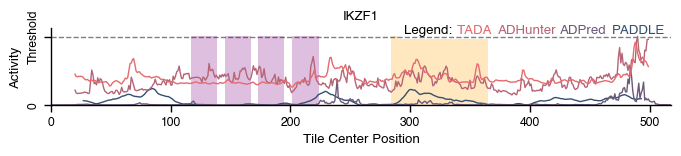

In [645]:
for i in [cc_TFs.index[2]]:
#for i in cc_TFs.dropna().index:
    fig, ax = plt.subplots(figsize=(8, 1))
    plot_preds(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax);

# 4. Conservation

## 4A. CDS

In [373]:
cds_phylo_P = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_zoonomia_all_TF_cds/*")
for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]
    df = pd.read_csv(path, sep = "\t", header = None)
    cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {3: "ENST", 8: "PhyloP"})
cds_phylo_P

,0,1,2,ENST,4,5,6,7,PhyloP
0,2,27149134,27149135,ENST00000296096,1,2,27149134,27149135,4.624
1,2,27149135,27149136,ENST00000296096,1,2,27149135,27149136,6.891
2,2,27149136,27149137,ENST00000296096,1,2,27149136,27149137,1.666
3,2,27149137,27149138,ENST00000296096,1,2,27149137,27149138,5.833
4,2,27149138,27149139,ENST00000296096,1,2,27149138,27149139,-0.157
...,...,...,...,...,...,...,...,...,...
3850,16,49822681,49822682,ENST00000561648,-1,16,49822681,49822682,0.452
3851,16,49822682,49822683,ENST00000561648,-1,16,49822682,49822683,-0.104
3852,16,49822683,49822684,ENST00000561648,-1,16,49822683,49822684,-0.824
3853,16,49822684,49822685,ENST00000561648,-1,16,49822684,49822685,0.588


In [696]:
def plot_cds_trace(gene, DBD_coords, AD_coords, RD_coords, ax, x_axis_spacing = 600):
    ENST = cc_names[cc_names["Gene"] == gene]["ENST"].iloc[0]
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    
    if ENST_phylo_P[4].iloc[0] == -1:
        ascending = False
    else: 
        #print("pos")
        ascending = True
        
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    ENST_phylo_P["cds_nt"] = np.arange(len(ENST_phylo_P))

    smoothed = lowess(ENST_phylo_P['PhyloP'], 
                      ENST_phylo_P["cds_nt"], 
                      frac=0.01)  # Adjust frac for smoothness
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])

    sns.scatterplot(data=ENST_phylo_P, 
                    x="cds_nt", 
                    y='PhyloP', 
                    color='black', 
                    alpha = 0.1, 
                    size = 10, 
                    legend = False,
                   ax = ax)    
    sns.lineplot(data=smoothed_df, x="cds_nt", y='smoothed', color='black', ax = ax, lw = 1)

    new_DBD_coords = []
    new_AD_coords = []

    for start, end in DBD_coords:
        new_DBD_coords.append((start * 3, end * 3))
    
    for start, end in AD_coords:
        new_AD_coords.append((start * 3, end * 3))
        
    plot_domain_rectangles(new_DBD_coords, new_AD_coords, RD_coords, max(ENST_phylo_P["PhyloP"]) - min(ENST_phylo_P["PhyloP"]) + 2, 
                           RD = False, AD_text = False, alpha = 0.25,
                          DBD_y = min(ENST_phylo_P["PhyloP"]) - 1, 
                           AD_y = min(ENST_phylo_P["PhyloP"]) - 1, 
                           RD_y = min(ENST_phylo_P["PhyloP"]) - 1, 
                           ax = ax)
    
    sns.despine()
    ax.set_xlim(0, max(smoothed_df["cds_nt"]) + 1)
    ax.set_ylim(min(ENST_phylo_P["PhyloP"]) - 1, max(ENST_phylo_P["PhyloP"]) + 1)
    ax.set_ylabel("PhyloP")
    ax.set_xlabel('CDS Nucloetide', color = sns.color_palette('muted')[0], labelpad = 0) 

    ax.set_xticks(np.arange(0, max(ENST_phylo_P["cds_nt"]) + 1, x_axis_spacing))
    ax.tick_params(axis='x', colors=sns.color_palette('muted')[0])
    ax.spines["bottom"].set_color(sns.color_palette('muted')[0])
    
    plt.axhline(0, color = "gray", linestyle = "--", alpha = 0.5)
    plt.title(gene)

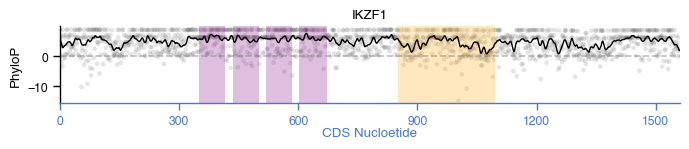

In [697]:
for i in [cc_TFs.index[2]]:
#for i in cc_TFs.dropna().index:
    fig, ax = plt.subplots(figsize=(8, 1))
    plot_cds_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax, x_axis_spacing = 300);

## 4b. Codon alignment conservation

In [661]:
def plot_prot_trace(gene, DBD_coords, AD_coords, RD_coords, ax, x_axis_spacing = 600):
    percent_identities = pd.read_csv("../data/zoonomia_toga_mca/prot_alignment_percent_identities/" + gene, index_col = 0)
    display(percent_identities)
    
    # sns.scatterplot(data = percent_identities, x = "pos", y = "percent_identity", ax = ax, edgecolor = "none", s = 1)
    # display(percent_identities)


    smoothed = lowess(percent_identities['percent_identity'], 
                      percent_identities["pos"], 
                      frac=0.01)  # Adjust frac for smoothness
    smoothed_df = pd.DataFrame(smoothed, columns=["pos", 'smoothed'])

    sns.scatterplot(data=percent_identities, 
                    x="pos", 
                    y='percent_identity', 
                    color='black', 
                    alpha = 0.1, 
                    size = 10, 
                    legend = False,
                   ax = ax)    
    sns.lineplot(data=smoothed_df, x="pos", y='smoothed', color='black', ax = ax, lw = 1)

    sns.despine()
    ax.set_ylabel("% Identity")
    ax.set_ylim(0, 100)
    ax.set_xlim(0, len(smoothed_df) + 1)

    plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, 100, 
                           RD = False, AD_text = False, alpha = 0.25,
                          DBD_y = 0, 
                           AD_y = 0, 
                           RD_y = 0, 
                           ax = ax)

,AA,percent_identity,pos
0,M,95.348837,0
1,D,90.486258,1
2,A,81.183932,2
3,D,93.023256,3
4,E,87.949260,4
...,...,...,...
514,R,94.291755,569
515,F,81.395349,570
516,H,90.909091,571
517,M,78.012685,572


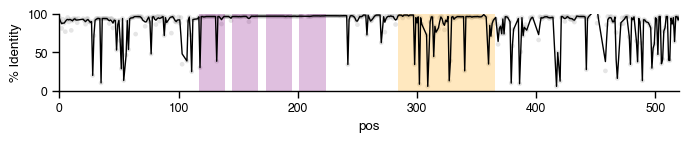

In [673]:
for i in [cc_TFs.index[2]]:
#for i in cc_TFs.dropna().index:
    fig, ax = plt.subplots(figsize=(8, 1))
    plot_prot_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax);

# 5. Variant lists

In [699]:
pd.read_csv("../soto_analysis/outputs/mutations/cds_gnomad_snv_classified/ENST00000056233.bed", sep = "\t", header = None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,7,26152498,26152499,Q9Y4A8,ENST00000056233,+,7,26152498,26152499,A,T,1.696534e-06,M,L,No-Syn
1,7,26152500,26152501,Q9Y4A8,ENST00000056233,+,7,26152500,26152501,G,A,8.454186e-07,M,I,No-Syn
2,7,26152500,26152501,Q9Y4A8,ENST00000056233,+,7,26152500,26152501,G,T,1.099044e-05,M,I,No-Syn
3,7,26152503,26152504,Q9Y4A8,ENST00000056233,+,7,26152503,26152504,G,T,8.378788e-07,K,N,No-Syn
4,7,26152505,26152506,Q9Y4A8,ENST00000056233,+,7,26152505,26152506,A,G,1.462025e-06,H,R,No-Syn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,7,26185775,26185776,Q9Y4A8,ENST00000056233,+,7,26185775,26185776,G,C,1.457307e-05,R,T,No-Syn
1761,7,26185775,26185776,Q9Y4A8,ENST00000056233,+,7,26185775,26185776,G,T,1.402499e-06,R,I,No-Syn
1762,7,26185776,26185777,Q9Y4A8,ENST00000056233,+,7,26185776,26185777,A,C,7.012170e-07,R,S,No-Syn
1763,7,26185778,26185779,Q9Y4A8,ENST00000056233,+,7,26185778,26185779,A,G,4.028533e-06,K,R,No-Syn


In [703]:
pd.read_csv("../soto_analysis/outputs/mutations/cds_clinvar_for_15_snv_classified/ENST00000241001.bed", sep = "\t", header = None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,11,31789934,31789935,P26367,ENST00000241001,-,11,31789934,31789935,T,A,.,*,L,No-Syn
1,11,31789934,31789935,P26367,ENST00000241001,-,11,31789934,31789935,T,C,.,*,*,Syn
2,11,31789935,31789936,P26367,ENST00000241001,-,11,31789935,31789936,A,G,.,*,Q,No-Syn
3,11,31789935,31789936,P26367,ENST00000241001,-,11,31789935,31789936,A,T,.,*,K,No-Syn
4,11,31789936,31789937,P26367,ENST00000241001,-,11,31789936,31789937,C,A,.,Q,H,No-Syn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,11,31802825,31802826,P26367,ENST00000241001,-,11,31802825,31802826,C,G,.,G,R,No-Syn
165,11,31806408,31806409,P26367,ENST00000241001,-,11,31806408,31806409,C,A,.,M,I,No-Syn
166,11,31806408,31806409,P26367,ENST00000241001,-,11,31806408,31806409,C,T,.,M,I,No-Syn
167,11,31806410,31806411,P26367,ENST00000241001,-,11,31806410,31806411,T,C,.,M,V,No-Syn


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

sns.set_context('paper')

def plot_one_AD_track(AD):
    AD_pt_vars = pt_vars[pt_vars["Gene Name"]  == AD]
    AD_gnomad = gnomad[gnomad["Gene Name"] == AD]

     # Create the top plot (original histogram)
    min_pos = cc_names[cc_names["Gene Name"] == AD]["start"].iloc[0]
    max_pos =cc_names[cc_names["Gene Name"] == AD]["end"].iloc[0]
    
    # Create a figure with two subplots (top and bottom) sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8.5 * (max_pos - min_pos) / 150, 11/15), sharex=True, dpi = 300)
    

    sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
                 x="pos", kde=False, edgecolor = "none", palette = color_palette,
                 hue="list", element="bars", legend=False, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax1)
    
    # Add title to the top plot
    ax1.set_ylabel(AD, rotation=0, labelpad=50, fontsize=10)  # Gene name on the left
    sns.despine(ax=ax1)
    
    sns.histplot(data=AD_gnomad, stat="count", 
                 x="pos", kde=False, color = color_palette["gnomAD"], edgecolor = "none", label = "gnomAD",
                 element="bars", bins=np.arange(min_pos, max_pos + 1, 1), ax=ax2)

    # ax1_ymin, ax_1ymax = ax1.get_ylim()
    # ax2_ymin, ax_2ymax = ax2.get_ylim()
    #ymin, ymax = min(ax1_ymin, ax2_ymin), max(ax_1ymax, ax_2ymax)
    ymin, ymax = 0, 10
    
    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)
    
    # Invert the y-axis for the bottom plot
    ax2.invert_yaxis()
    ax2.set_ylabel("        Count")
    ax2.set_xticks(np.arange(min_pos, max_pos + 1, 20))
    ax2.set_xlim(min_pos, max_pos)
    ax2.set_xlabel("")

    
    # Add title to the bottom plot
    sns.despine()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

    

cc_names = cc_names.sort_values(by = "len", ascending = True)

# with PdfPages('AD_tracks.pdf') as pdf:

for AD in cc_names["Gene Name"]:
    plot_one_AD_track(AD)

# Manually create the legend
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["SPARK"], markersize=10, label="SPARK"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["COSMIC"], markersize=10, label="COSMIC"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["ClinVar"], markersize=10, label="ClinVar"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["gnomAD"], markersize=10, label="gnomAD")
]

# Add the legend to the plot
plt.legend(handles=legend_labels, loc = (1.05 ,-0.5))

# Show the plot
plt.show()